<a href="https://colab.research.google.com/github/Gkcoli/CCDEPLRL_EXERCISES_COM222/blob/main/Exercise_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7

Text Generation using LSTM

In [233]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [234]:
tokenizer = Tokenizer()

!wget --no-check-certificate \
    https://raw.githubusercontent.com/cibernox/storyteller/refs/heads/master/snow-white.txt \
    -O /tmp/snowwhite.txt

data = open('/tmp/snowwhite.txt').read()

--2025-05-27 09:05:56--  https://raw.githubusercontent.com/cibernox/storyteller/refs/heads/master/snow-white.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520 (1.5K) [text/plain]
Saving to: ‘/tmp/snowwhite.txt’

/tmp/snowwhite.txt  100%[===================>]   1.48K  --.-KB/s    in 0s      

2025-05-27 09:05:56 (18.6 MB/s) - ‘/tmp/snowwhite.txt’ saved [1520/1520]



In [235]:
corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

## Create the LSTM model

1. Build an LSTM

In [236]:
# Fix the incomplete input
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len - 1))
# Add return_sequences=True to the Bidirectional layer
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
# Ensure the number of units is an integer
model.add(Dense(int(total_words/2), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
optimizer = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [237]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(monitor='loss', patience=5, verbose=1),
    # Model checkpoint to save the best model based on validation loss
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
    # Reduce learning rate when the validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=0.0001)
]


In [238]:
history = model.fit(predictors, label, epochs=100, verbose=1, validation_split=0.1)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.0118 - loss: 5.7477 - val_accuracy: 0.0000e+00 - val_loss: 5.5343
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0325 - loss: 4.9515 - val_accuracy: 0.0000e+00 - val_loss: 5.4900
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0806 - loss: 4.6745 - val_accuracy: 0.0000e+00 - val_loss: 5.7601
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0844 - loss: 4.4560 - val_accuracy: 0.0000e+00 - val_loss: 6.5661
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0468 - loss: 4.4722 - val_accuracy: 0.0400 - val_loss: 6.3024
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0789 - loss: 4.1912 - val_accuracy: 0.0400 - val_loss: 6.8277
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0840 - loss: 4.0769 - val_accuracy: 0.0400 - val_loss: 7.4976
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1224 - loss: 3.8915 - val_accuracy: 0.

In [239]:
#print accuracy
print(history.history['accuracy'][-1])

0.9636363387107849


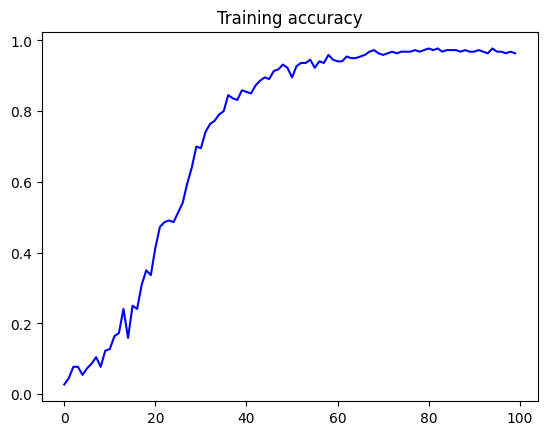

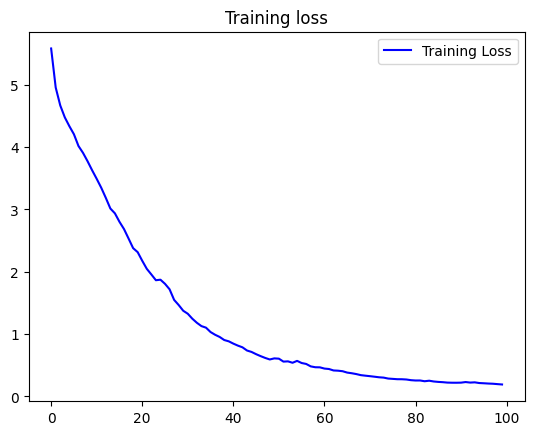

In [240]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

## B. Generate texts


In [298]:
def generate_text(seed_text, next_words=40, temperature=8):
    output = seed_text
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([output])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        preds = model.predict(token_list, verbose=0)[0]
        preds = np.log(preds + 1e-8) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        predicted = np.random.choice(len(preds), p=preds)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        if output_word == "":
            break
        output += " " + output_word
    return output

In [269]:
seed_text = "Snow White lived in the forest with"
print(generate_text(seed_text, next_words=100, temperature=10))

Snow White lived in the forest with mumbled spite snow curled intc wild always grew feel rich under mirror strange black woman called everyone always they called attracted ran told her spite furious wild


In [270]:
seed_text = "Once Upon A Time"
print(generate_text(seed_text, next_words=100, temperature=8))

Once Upon A Time night great a asked this asked great asleep led the she plotting thump leaving but happy who that an of heart great become asleep alone the not snow her at snow servants fair but came came do castle led rid fair trusty become rustlings she plotting very she long asked off get tiredness woman him wall calling excuse off wall courage alone her blue stepmother off wall rich however eyes by sitting spot are tiredness sounds who mumbled castle excuse excuse lady stepmother bitterly up thought dreadful wicked him spot jealousy stepmother rid however girl sitting sounds jealousy this it


In [271]:
seed_text = "The queen looked into the mirror and said"
print(generate_text(seed_text, next_words=100, temperature=10))

The queen looked into the mirror and said of everyone hair spite the who grew every it always not in mumbled last off black courage on lady attracted away called courage failed with snow white intc but led intc black away heard with long did courage grew feel majesty that once white attracted magic prince's you that wall though would in curled under at thump heard your sounds rid contented sitting great asleep servant are fatal and under girl under agreed would overcome one forest plotting heard off furious great feel beautiful curled contented once return hair the blue he tiredness cry long a agreed delicate alone an


In [272]:
seed_text = "One day, Snow White found a small cottage and"
print(generate_text(seed_text, next_words=100, temperature=10))

One day, Snow White found a small cottage and tree excuse skin servant spite pretty so land tree beside fatal to told wall take forest beside overcome return ran he him but magic under by strange whenever led fell fair all bribed deed excuse majesty everyone failed however become curled jealous heard loveliest blue an would spying the fair she her castle bitterly with on did are failed beautiful she girl black he spite plotting sure return skin thought in alone tiredness in too the thump bitterly began in whenever an however pretty day say always asleep up plotting with a thought with wild fair sure day calling very


In [273]:
seed_text = "Snow white ate a poisonous"
print(generate_text(seed_text, next_words=1, temperature=8))

Snow white ate a poisonous did


In [313]:
seed_text = "Snow white is the"
print(generate_text(seed_text, next_words=4, temperature=2))

Snow white is the loveliest in the so
